In [1]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.14.0
Eager execution: True


In [4]:
# 下载数据集
# 鸢尾花分类问题是监督式机器学习的一个示例：模型通过包含标签的样本加以训练。在非监督式机器学习中，样本不包含标签。
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url), origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
Local copy of the dataset file: C:\Users\bxc2018003.BXC\.keras\datasets\iris_training.csv


In [8]:
# 检查前 5 行数据 （此命令查看不了，手动打开文件吧！！！）
head -n5 {train_dataset_fp}

SyntaxError: invalid syntax (<ipython-input-8-76f0cbf049ea>, line 1)

In [9]:
# 120,4,setosa,versicolor,virginica
# 6.4,2.8,5.6,2.2,2
# 5.0,2.3,3.3,1.0,1
# 4.9,2.5,4.5,1.7,2
# 4.9,3.1,1.5,0.1,0

# 第一行是标题，其中包含数据集信息：共有 120 个样本。每个样本都有四个特征和一个标签名称，标签名称有三种可能。
# 后面的行是数据记录，每个样本各占一行，其中：
#        前四个字段是特征：即样本的特点。在此数据集中，这些字段存储的是代表花卉测量值的浮点数。
#       最后一列是标签：即我们想要预测的值。对于此数据集，该值为 0、1 或 2 中的某个整数值（每个值分别对应一个花卉名称）。

# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [10]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica'] # 0：山鸢尾 1：变色鸢尾  2：维吉尼亚鸢尾

# 使用 make_csv_dataset 函数将csv文件数据解析为合适的格式， 返回 (features, label) 对的 tf.data.Dataset
batch_size = 32   # 每组样本数为32

train_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

W0810 20:40:23.982721 16596 deprecation.py:323] From <ipython-input-10-1c125dfa1b81>:11: make_csv_dataset (from tensorflow.contrib.data.python.ops.readers) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.experimental.make_csv_dataset(...)`.
W0810 20:40:24.255989 16596 deprecation.py:323] From D:\anaconda3\lib\site-packages\tensorflow\python\data\experimental\ops\readers.py:499: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


In [11]:
features, labels = next(iter(train_dataset))

features  #  是一个字典：{'feature_name': value}

OrderedDict([('sepal_length',
              <tf.Tensor: id=65, shape=(32,), dtype=float32, numpy=
              array([5. , 6.5, 6.2, 4.9, 4.6, 5.2, 4.9, 6.4, 5.5, 6.7, 7.7, 6.5, 6.1,
                     5.8, 4.9, 5.4, 6.3, 5.1, 6.5, 4.7, 6. , 6. , 6.8, 6.6, 5. , 4.9,
                     5.4, 5. , 6.3, 6.6, 5. , 5.1], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=66, shape=(32,), dtype=float32, numpy=
              array([3.4, 2.8, 3.4, 3. , 3.1, 3.5, 2.4, 2.8, 2.6, 3. , 2.8, 3. , 2.6,
                     2.7, 2.5, 3.9, 3.4, 2.5, 3. , 3.2, 3. , 2.9, 3. , 2.9, 3.5, 3.1,
                     3.7, 3.2, 2.3, 3. , 3. , 3.8], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=63, shape=(32,), dtype=float32, numpy=
              array([1.5, 4.6, 5.4, 1.4, 1.5, 1.5, 3.3, 5.6, 4.4, 5.2, 6.7, 5.2, 5.6,
                     5.1, 4.5, 1.7, 5.6, 3. , 5.8, 1.3, 4.8, 4.5, 5.5, 4.6, 1.3, 1.5,
                     1.5, 1.2, 4.4, 4.4, 1.6, 1.6],

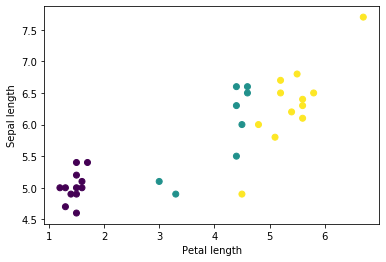

In [12]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,         # c表示color，可以是一个数组， cmap表示colormap
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length");

In [13]:
# 要简化模型构建步骤，请创建一个函数以将特征字典重新打包为形状为 (batch_size, num_features) 的单个数组。
# 此函数使用 tf.stack 方法，该方法从张量列表中获取值，并创建指定维度的组合张量。
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

In [14]:
# 然后使用 tf.data.Dataset.map 方法将每个 (features,label) 对的 features 打包到训练数据集中
train_dataset = train_dataset.map(pack_features_vector)

In [15]:
# Dataset 的 features 元素现在是形状为 (batch_size, num_features) 的数组。我们来看看前几个样本：
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[5.  3.4 1.5 0.2]
 [6.5 2.8 4.6 1.5]
 [6.2 3.4 5.4 2.3]
 [4.9 3.  1.4 0.2]
 [4.6 3.1 1.5 0.2]], shape=(5, 4), dtype=float32)


In [16]:
# 全连接神经网络（密集层）：一个层中的神经元将从上一层中的每个神经元获取输入连接
#  创建模型
# 本示例中，采用的是 2 个密集层（分别包含 10 个节点）以及 1 个输出层（包含 3 个代表标签预测的节点）
# 第一个层的 input_shape 参数对应该数据集中的特征数量，它是一项必需参数。
# 激活函数有很多，但隐藏层通常使用 ReLU。
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

In [17]:
# 使用模型
# 每个样本针对每个类别返回一个对数。
predictions = model(features)
predictions[:5]

<tf.Tensor: id=234, shape=(5, 3), dtype=float32, numpy=
array([[0.19813728, 1.0192789 , 1.4877338 ],
       [0.246719  , 0.9744531 , 1.028918  ],
       [0.5740256 , 0.96469194, 0.748634  ],
       [0.0989337 , 0.9502616 , 1.4090102 ],
       [0.18451333, 0.94135386, 1.3228387 ]], dtype=float32)>

In [18]:
# 要将这些对数转换为每个类别的概率，请使用 softmax 函数：
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=240, shape=(5, 3), dtype=float32, numpy=
array([[0.14483488, 0.32922322, 0.52594197],
       [0.19023491, 0.3938593 , 0.41590577],
       [0.27257273, 0.40285307, 0.32457414],
       [0.1418598 , 0.33234286, 0.5257973 ],
       [0.1599215 , 0.34087765, 0.4992008 ]], dtype=float32)>

In [20]:
# 对每个类别执行 tf.argmax 运算可得出预测的类别索引
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("       Labels: {}".format(labels))

Prediction: [2 2 1 2 2 2 1 2 1 2 2 1 2 1 1 2 1 2 1 2 1 1 2 2 2 2 2 2 2 2 2 2]
       Labels: [0 1 2 0 0 0 1 2 1 2 2 2 2 2 2 0 2 1 2 0 2 1 2 1 0 0 0 0 1 1 0 0]


In [21]:
# 训练模型： 定义损失和梯度函数
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 1.343332290649414


In [22]:
# 使用 tf.GradientTape context 计算用于优化模型的梯度。
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [24]:
# 创建优化器
# 此模型使用的是 tf.train.GradientDescentOptimizer，它可以实现随机梯度下降法 (SGD)。
# learning_rate 用于设置每次迭代（向下行走）的步长。这是一个超参数，您通常需要调整此参数以获得更好的结果。
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

global_step = tf.train.get_or_create_global_step()

In [25]:
# 计算单个优化步骤
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(), loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.variables), global_step)

print("Step: {},            Loss: {}".format(global_step.numpy(),loss(model, features, labels).numpy()))

Step: 0, Initial Loss: 1.343332290649414
Step: 1,            Loss: 1.3066905736923218


In [26]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step)

    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 20 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.238, Accuracy: 26.667%
Epoch 020: Loss: 0.652, Accuracy: 74.167%
Epoch 040: Loss: 0.477, Accuracy: 81.667%
Epoch 060: Loss: 0.406, Accuracy: 86.667%
Epoch 080: Loss: 0.359, Accuracy: 91.667%
Epoch 100: Loss: 0.319, Accuracy: 93.333%
Epoch 120: Loss: 0.281, Accuracy: 95.000%
Epoch 140: Loss: 0.247, Accuracy: 96.667%
Epoch 160: Loss: 0.218, Accuracy: 97.500%
Epoch 180: Loss: 0.193, Accuracy: 97.500%
Epoch 200: Loss: 0.174, Accuracy: 97.500%


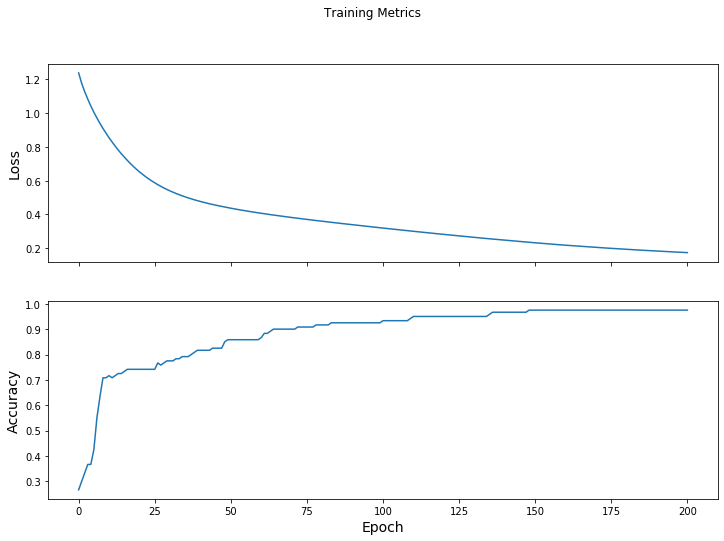

In [27]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results);

In [28]:
# 设置测试数据集
test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [30]:
test_dataset = tf.contrib.data.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

In [31]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


In [32]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: id=105791, shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 2],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]])>

In [33]:
# 对无标签样本进行预测
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (98.8%)
Example 1 prediction: Iris versicolor (87.2%)
Example 2 prediction: Iris virginica (77.2%)
